## 分析目標
+ 資料內容：
    + 資料來源：東森新聞
    + 版別：國際、運動、娛樂  

* 分析主題：將東森新聞三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行測試文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 測試模型

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}

In [3]:
font_set

{'Agency FB',
 'Algerian',
 'Arial',
 'Arial Rounded MT Bold',
 'BIZ UDGothic',
 'BIZ UDMincho',
 'Bahnschrift',
 'Baskerville Old Face',
 'Bauhaus 93',
 'Bell MT',
 'Berlin Sans FB',
 'Berlin Sans FB Demi',
 'Bernard MT Condensed',
 'Blackadder ITC',
 'Bodoni MT',
 'Book Antiqua',
 'Bookman Old Style',
 'Bookshelf Symbol 7',
 'Bradley Hand ITC',
 'Britannic Bold',
 'Broadway',
 'Brush Script MT',
 'Calibri',
 'Californian FB',
 'Calisto MT',
 'Cambria',
 'Candara',
 'Castellar',
 'Centaur',
 'Century',
 'Century Gothic',
 'Century Schoolbook',
 'Chiller',
 'Colonna MT',
 'Comic Sans MS',
 'Consolas',
 'Constantia',
 'Cooper Black',
 'Copperplate Gothic Bold',
 'Copperplate Gothic Light',
 'Corbel',
 'Courier New',
 'Curlz MT',
 'DFKai-SB',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'DengXian',
 'Dubai',
 'Ebrima',
 'Edwardian Script ITC',
 'Elephant',
 'Engravers MT',
 'Eras Bold ITC',
 'Eras Demi ITC',
 'Eras Light ITC',
 '

Text(0.5, 1.0, '聲量圖')

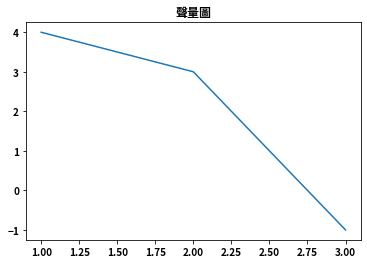

In [4]:

font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans TC"]
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`ebc_news_03.csv`裡面包含了要分析的 ebc 新聞資料。首先我們先看文集的基本資料，並做文集前處理。

In [5]:
ebc = pd.read_csv("raw_data/raw_data.csv",index_col=0)  # 匯資料
ebc.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,877,Selina認愛了！小鮮肉男友首曝光 親密互動全被拍｜東森新聞,https://news.ebc.net.tw/news/article/305059,2022-03-03 12:44:00,娛樂,Selina（任家萱）離婚5年，今（3日）傳出好消息！她被陸媒拍到和神秘男子手勾手回酒店，一...,EBC
1,4490,算命阿姨發功 阿翰奪「走鐘獎最大獎」哽咽｜東森新聞,https://news.ebc.net.tw/news/article/342619,2022-10-30 11:42:00,娛樂,YouTuber最高榮譽殿堂，「走鐘獎」邁入第四屆，不少YouTuber共襄盛舉。以「九天玄...,EBC
2,1638,為照顧罹癌母！35歲男星突閃退演藝圈 媽媽2個月後逝世｜東森新聞,https://news.ebc.net.tw/news/article/312350,2022-04-15 06:40:00,娛樂,大陸歌手劉維曾赴韓拜師朴軫永，成為JYP首位中國練習生，後來在中國好聲音演唱范曉萱的歌曲因為...,EBC


In [6]:
# 看看有幾篇文章
print(f"number of posts: {ebc.shape[0]}")
print(f"date range: {(ebc['artDate'].min(), ebc['artDate'].max())}")
print(f"category: \n{ebc['artCatagory'].value_counts()}")


number of posts: 4098
date range: ('2022-01-01 06:07:00', '2023-04-29 22:43:00')
category: 
artCatagory
娛樂    1366
國際    1366
體育    1366
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [7]:
# 移除網址格式
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,877,認愛了小鮮肉男友首曝光親密互動全被拍東森新聞,https://news.ebc.net.tw/news/article/305059,2022-03-03 12:44:00,娛樂,任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子手勾手回酒店一路上還不停跳躍看起來心情非常好...,EBC
1,4490,算命阿姨發功阿翰奪走鐘獎最大獎哽咽東森新聞,https://news.ebc.net.tw/news/article/342619,2022-10-30 11:42:00,娛樂,最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女紅遍全台的阿翰靠著算命阿姨奪下最佳影片獎在...,EBC
2,1638,為照顧罹癌母歲男星突閃退演藝圈媽媽個月後逝世東森新聞,https://news.ebc.net.tw/news/article/312350,2022-04-15 06:40:00,娛樂,大陸歌手劉維曾赴韓拜師朴軫永成為首位中國練習生後來在中國好聲音演唱范曉萱的歌曲因為你是范曉萱...,EBC


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [8]:
# 留下 content
ebc["content"] = ebc["artTitle"] + ebc["artContent"]
ebc = ebc[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
ebc.head()

,content,artUrl,artCatagory
0,認愛了小鮮肉男友首曝光親密互動全被拍東森新聞任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子...,https://news.ebc.net.tw/news/article/305059,娛樂
1,算命阿姨發功阿翰奪走鐘獎最大獎哽咽東森新聞最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女...,https://news.ebc.net.tw/news/article/342619,娛樂
2,為照顧罹癌母歲男星突閃退演藝圈媽媽個月後逝世東森新聞大陸歌手劉維曾赴韓拜師朴軫永成為首位中國...,https://news.ebc.net.tw/news/article/312350,娛樂
3,華燈行駛畫面怎拍花絮揭燈光師要會多少舞步東森新聞華燈初上第三季日上線許多人為了避免被旁人爆雷...,https://news.ebc.net.tw/news/article/308225,娛樂
4,張孝全陳昊森主演罪後真相女性觀眾口碑爆棚東森新聞年底最受矚目的犯罪懸疑國片由新銳導演陳奕甫執...,https://news.ebc.net.tw/news/article/342847,娛樂


In [9]:
# 看看有幾篇文章
print(f"total docs: {ebc.shape[0]}")


total docs: 4098


### 2.2 斷詞

In [10]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [11]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [12]:
ebc["words"] = ebc["content"].apply(getToken).map(" ".join)
ebc.head()

Building prefix dict from d:\vscode\sna_group3\dict\dict.txt.big ...
Loading model from cache C:\Users\TSH13\AppData\Local\Temp\jieba.ud39a693a3199c8a92d2c9920519551c6.cache
Loading model cost 0.852 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,認愛了小鮮肉男友首曝光親密互動全被拍東森新聞任家萱離婚年今日傳出好消息她被陸媒拍到和神秘男子...,https://news.ebc.net.tw/news/article/305059,娛樂,認愛了 鮮肉 男友 曝光 親密 互動 東森 新聞 任家萱 離婚 今日 傳出 好消息 陸媒 神...
1,算命阿姨發功阿翰奪走鐘獎最大獎哽咽東森新聞最高榮譽殿堂走鐘獎邁入第四屆不少共襄盛舉以九天玄女...,https://news.ebc.net.tw/news/article/342619,娛樂,算命 阿姨 發功 阿翰 奪走 鐘獎 大獎 哽咽 東森 新聞 最高 榮譽 殿堂 鐘獎 邁入 第...
2,為照顧罹癌母歲男星突閃退演藝圈媽媽個月後逝世東森新聞大陸歌手劉維曾赴韓拜師朴軫永成為首位中國...,https://news.ebc.net.tw/news/article/312350,娛樂,照顧 罹癌 母歲 男星 突閃退 演藝圈 媽媽 逝世 東森 新聞 大陸歌手 劉維 赴韓 拜師 ...
3,華燈行駛畫面怎拍花絮揭燈光師要會多少舞步東森新聞華燈初上第三季日上線許多人為了避免被旁人爆雷...,https://news.ebc.net.tw/news/article/308225,娛樂,華燈 行駛 畫面 怎拍 花絮 燈光師 要會 舞步 東森 新聞 華燈初上 第三季 上線 許多 ...
4,張孝全陳昊森主演罪後真相女性觀眾口碑爆棚東森新聞年底最受矚目的犯罪懸疑國片由新銳導演陳奕甫執...,https://news.ebc.net.tw/news/article/342847,娛樂,張孝 全陳昊森 主演 真相 女性 觀眾 口碑 爆棚 東森 新聞 年底 最受 矚目 犯罪 懸疑...


### 2.3 資料集基本檢視

檢視資料內容

In [13]:
print(f"total posts: {len(ebc['artUrl'].unique())}")
print(f"category: \n{ebc['artCatagory'].value_counts()}")


total posts: 4098
category: 
artCatagory
娛樂    1366
國際    1366
體育    1366
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [14]:
data = ebc
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

380     小孩 高燒 拉血 老婆 求幫 急診 男星 今天 工作 重要 東森 新聞 鄒承恩 老婆 愛寶 ...
585     王世堅 炎上 柯文 哲當 來賓 官方 回應 曖昧 東森 新聞 泰爾 娛樂 宣布 經典 現場 ...
1369    本土 增例 印度 神童 恐怖 預言 命中 災難 時間 沒完 東森 新聞 今日 本土 確診 創...
1058    終極 男星 痛毆 女友 人傳 國城 乾兒子 經紀人 回應 東森 新聞 藝人 博焱 林曜晟 日...
1920    普丁 催生 怪獸 歐盟 態度 轉彎 一致 抗俄 關鍵 曝光 東森 新聞 歐盟 昨晚 俄羅斯 ...
Name: words, dtype: object
380     娛樂
585     娛樂
1369    國際
1058    娛樂
1920    國際
Name: artCatagory, dtype: object


In [15]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
娛樂    33.333333
國際    33.333333
體育    33.333333
Name: proportion, dtype: float64

train percentage :
artCatagory
體育    33.612273
國際    33.368201
娛樂    33.019526
Name: proportion, dtype: float64

test percentage :
artCatagory
娛樂    34.065041
國際    33.252033
體育    32.682927
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [16]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [17]:
X_train.head()

380     小孩 高燒 拉血 老婆 求幫 急診 男星 今天 工作 重要 東森 新聞 鄒承恩 老婆 愛寶 ...
585     王世堅 炎上 柯文 哲當 來賓 官方 回應 曖昧 東森 新聞 泰爾 娛樂 宣布 經典 現場 ...
1369    本土 增例 印度 神童 恐怖 預言 命中 災難 時間 沒完 東森 新聞 今日 本土 確診 創...
1058    終極 男星 痛毆 女友 人傳 國城 乾兒子 經紀人 回應 東森 新聞 藝人 博焱 林曜晟 日...
1920    普丁 催生 怪獸 歐盟 態度 轉彎 一致 抗俄 關鍵 曝光 東森 新聞 歐盟 昨晚 俄羅斯 ...
Name: words, dtype: object

In [18]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<2868x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 162068 stored elements in Compressed Sparse Row format>

In [19]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一下' '一些' '一位' '一出' '一同' '一名' '一場' '一天' '一定' '一家']


In [21]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'小孩': 354, '老婆': 752, '男星': 645, '今天': 76, '工作': 365, '重要': 919, '東森': 538, '新聞': 490, '日前': 496, '老公': 751, '照顧': 607, '孩子': 312, '沒想到': 580, '希望': 373, '對方': 346, '拒絕': 448, '十分': 184, '提到': 465, '之前': 52, '病毒': 660, '先生': 117, '幾天': 386, '影響': 395, '隔離': 951, '凌晨': 150, '成長': 428, '一次': 15, '補鈣': 795, '好吃': 301, '主動': 47, '醫院': 917, '狀況': 620, '需要': 964, '相當': 681, '難過': 959, '事後': 61, '解釋': 805, '結束': 724, '調整': 821, '擔心': 471, '拍攝': 447, '提出': 464, '這段': 880, '期間': 533, '好好': 302, '導致': 351, '手術': 436, '治療': 581, '問題': 233, '許多': 814, '喊話': 236, '謝謝': 823, '一直': 17, '婚姻': 308, '辛苦': 863, '節目': 709, '官方': 325, '回應': 244, '宣布': 327, '經典': 725, '現場': 626, '系列': 715, '邀請': 906, '社群': 696, '正式': 563, '名單': 224, '帶領': 375, '過去': 897, '年來': 379, '特別': 618, '面對': 968, '台北': 214, '市長': 372, '準備': 593, '舞台': 774, '透露': 872, '畫面': 649, '提醒': 466, '觀眾': 803, '演出': 594, '引起': 390, '網路上': 737, '討論': 809, '是否': 505, '精神': 714, '強調': 391, '要求': 800, '爆料': 612, '網友': 733, '擔任': 470, '表示': 792, '關

1

In [22]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(2868, 1000)
(1230, 1000)


In [23]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
clf.classes_


array(['國際', '娛樂', '體育'], dtype=object)

In [25]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['國際' '娛樂' '國際' '體育' '體育' '體育' '娛樂' '體育' '國際' '國際']


In [26]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1230, 3)


array([0.82006153, 0.06852466, 0.11141382])

In [27]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.93      0.92      0.92       409
          娛樂       0.92      0.92      0.92       419
          體育       0.98      0.99      0.98       402

    accuracy                           0.94      1230
   macro avg       0.94      0.94      0.94      1230
weighted avg       0.94      0.94      0.94      1230



In [28]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[376,  31,   2],
       [ 28, 385,   6],
       [  2,   4, 396]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '國際'), Text(0, 1.5, '娛樂'), Text(0, 2.5, '體育')])

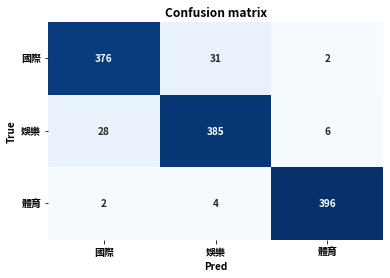

In [29]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [30]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(1230, 3)


array([1, 0, 0])

In [31]:
y_test.iloc[0]

'國際'

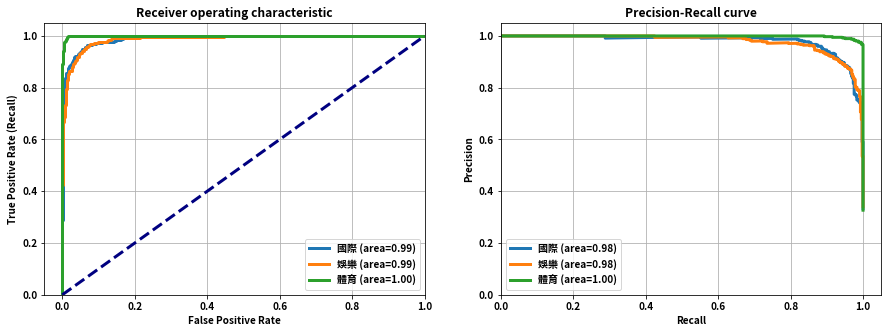

In [32]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [33]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04941482, 0.        , 0.04920539, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06182292, 0.        , 0.        ,
       0.        , 0.        , 0.05926295, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06236772, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [34]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.94      0.95      0.95       409
          娛樂       0.94      0.94      0.94       419
          體育       0.98      0.98      0.98       402

    accuracy                           0.96      1230
   macro avg       0.96      0.96      0.96      1230
weighted avg       0.96      0.96      0.96      1230



效果較佳，但其實兩個都很高了，可能因為三個類別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [35]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.19500041, 0.12399936, 0.12900138, 0.13900638, 0.10299993]),
 'score_time': array([0.00800061, 0.00699949, 0.00699735, 0.00799799, 0.00800037]),
 'test_f1_macro': array([0.93220826, 0.94079838, 0.92325843, 0.91950108, 0.92661157]),
 'test_precision_macro': array([0.93299775, 0.94116059, 0.92340004, 0.92037805, 0.92742248]),
 'test_recall_macro': array([0.93194436, 0.94061611, 0.92315049, 0.91972553, 0.92642188])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [36]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

              precision    recall  f1-score   support

          國際       0.91      0.90      0.90       957
          娛樂       0.90      0.91      0.90       947
          體育       0.98      0.97      0.98       964

    accuracy                           0.93      2868
   macro avg       0.93      0.93      0.93      2868
weighted avg       0.93      0.93      0.93      2868



d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


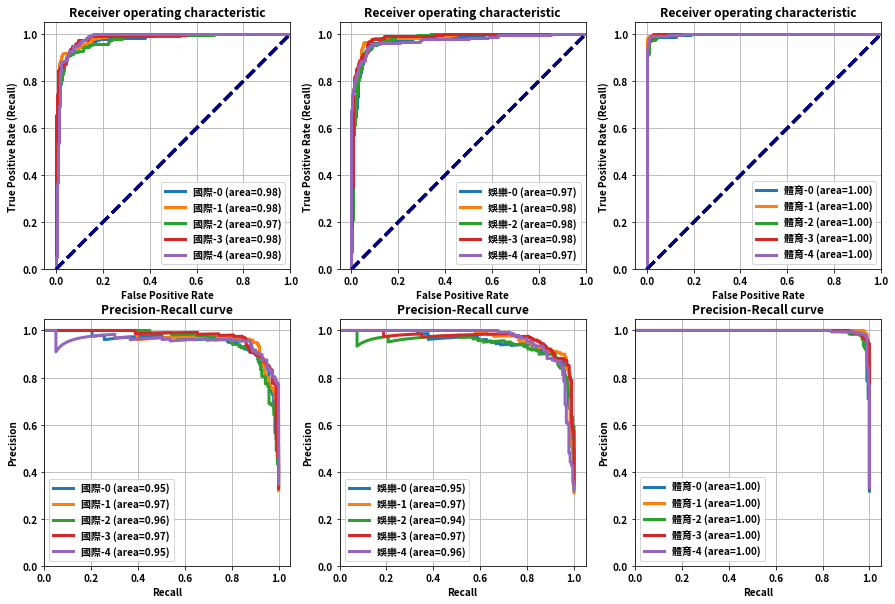

In [37]:
## 將三個新聞類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

## 4. 比較不同模型效果

In [38]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

              precision    recall  f1-score   support

          國際       0.91      0.90      0.90       957
          娛樂       0.90      0.91      0.90       947
          體育       0.98      0.97      0.98       964

    accuracy                           0.93      2868
   macro avg       0.93      0.93      0.93      2868
weighted avg       0.93      0.93      0.93      2868



d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


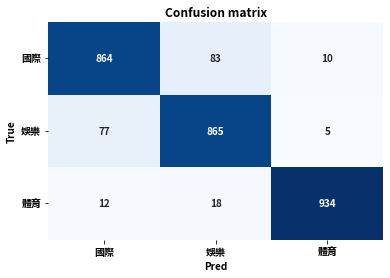

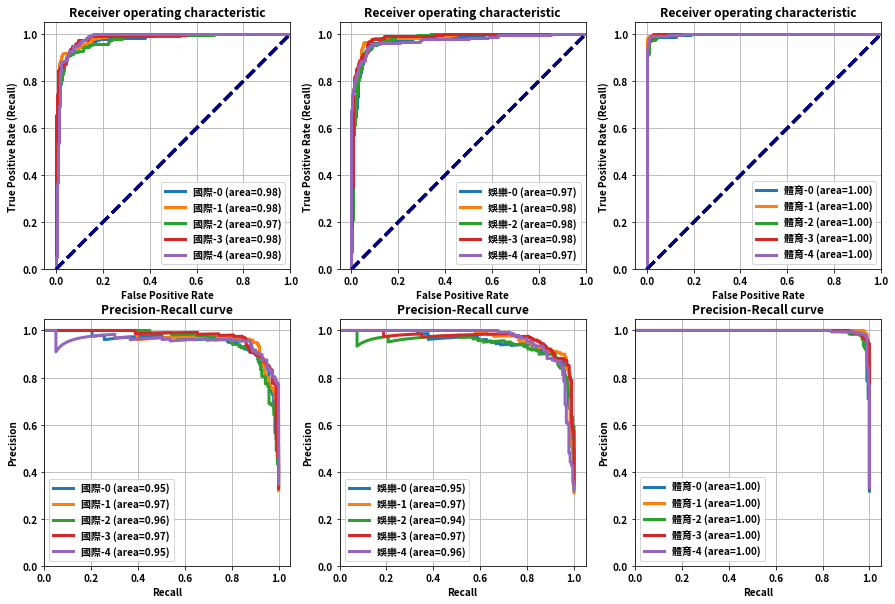

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic


d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

              precision    recall  f1-score   support

          國際       0.91      0.90      0.90       957
          娛樂       0.90      0.91      0.90       947
          體育       0.98      0.97      0.98       964

    accuracy                           0.93      2868
   macro avg       0.93      0.93      0.93      2868
weighted avg       0.93      0.93      0.93      2868



d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


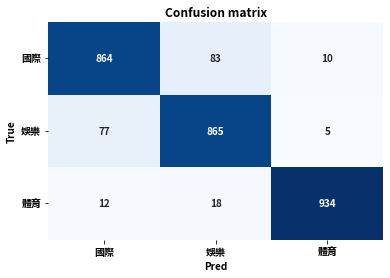

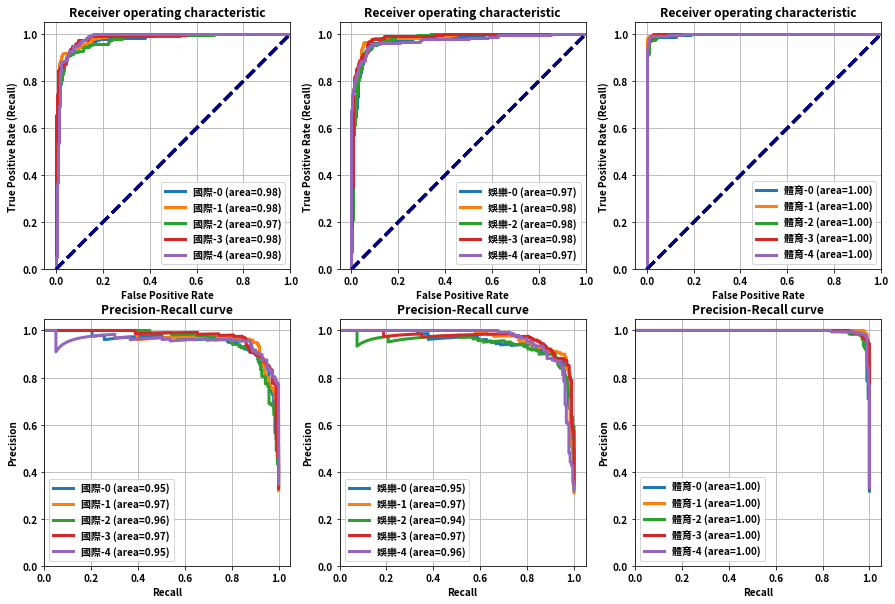

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


now training: clf_dtree
              precision    recall  f1-score   support

          國際       0.83      0.84      0.84       957
          娛樂       0.83      0.84      0.83       947
          體育       0.95      0.93      0.94       964

    accuracy                           0.87      2868
   macro avg       0.87      0.87      0.87      2868
weighted avg       0.87      0.87      0.87      2868



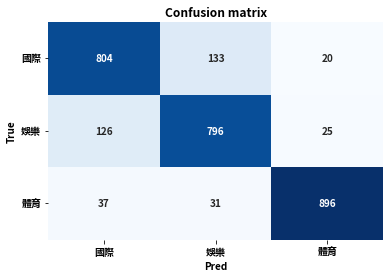

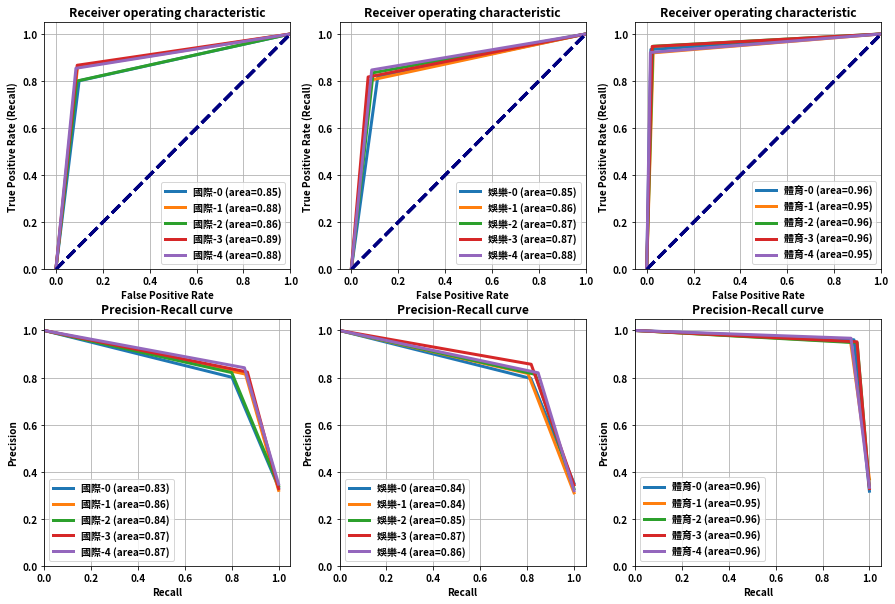

In [40]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [41]:
result_set['clf_logistic']

{'國際': {'precision': 0.906610703043022,
  'recall': 0.9028213166144201,
  'f1-score': 0.9047120418848169,
  'support': 957},
 '娛樂': {'precision': 0.8954451345755694,
  'recall': 0.9134107708553326,
  'f1-score': 0.9043387349712493,
  'support': 947},
 '體育': {'precision': 0.9841938883034773,
  'recall': 0.9688796680497925,
  'f1-score': 0.9764767381076841,
  'support': 964},
 'accuracy': 0.9285216178521618,
 'macro avg': {'precision': 0.9287499086406896,
  'recall': 0.9283705851731817,
  'f1-score': 0.9285091716545835,
  'support': 2868},
 'weighted avg': {'precision': 0.9290013575940684,
  'recall': 0.9285216178521618,
  'f1-score': 0.9287105235834554,
  'support': 2868}}

In [42]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9285216178521618,
 'macro avg': {'f1-score': 0.9285091716545835,
               'precision': 0.9287499086406896,
               'recall': 0.9283705851731817,
               'support': 2868},
 'weighted avg': {'f1-score': 0.9287105235834554,
                  'precision': 0.9290013575940684,
                  'recall': 0.9285216178521618,
                  'support': 2868},
 '國際': {'f1-score': 0.9047120418848169,
        'precision': 0.906610703043022,
        'recall': 0.9028213166144201,
        'support': 957},
 '娛樂': {'f1-score': 0.9043387349712493,
        'precision': 0.8954451345755694,
        'recall': 0.9134107708553326,
        'support': 947},
 '體育': {'f1-score': 0.9764767381076841,
        'precision': 0.9841938883034773,
        'recall': 0.9688796680497925,
        'support': 964}}


In [43]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.93      0.92      0.92       409
          娛樂       0.92      0.92      0.92       419
          體育       0.98      0.99      0.98       402

    accuracy                           0.94      1230
   macro avg       0.94      0.94      0.94      1230
weighted avg       0.94      0.94      0.94      1230



* logistic 的模型表現比決策樹的好一點。
* 另外用 tfidf 作為 `vectorizer`，效果更好。

              precision    recall  f1-score   support

          國際       0.94      0.93      0.93       957
          娛樂       0.92      0.94      0.93       947
          體育       0.99      0.97      0.98       964

    accuracy                           0.95      2868
   macro avg       0.95      0.95      0.95      2868
weighted avg       0.95      0.95      0.95      2868



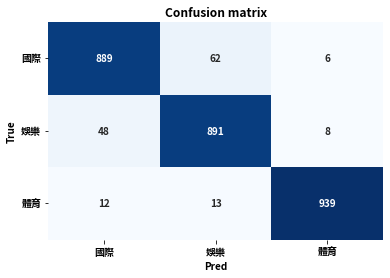

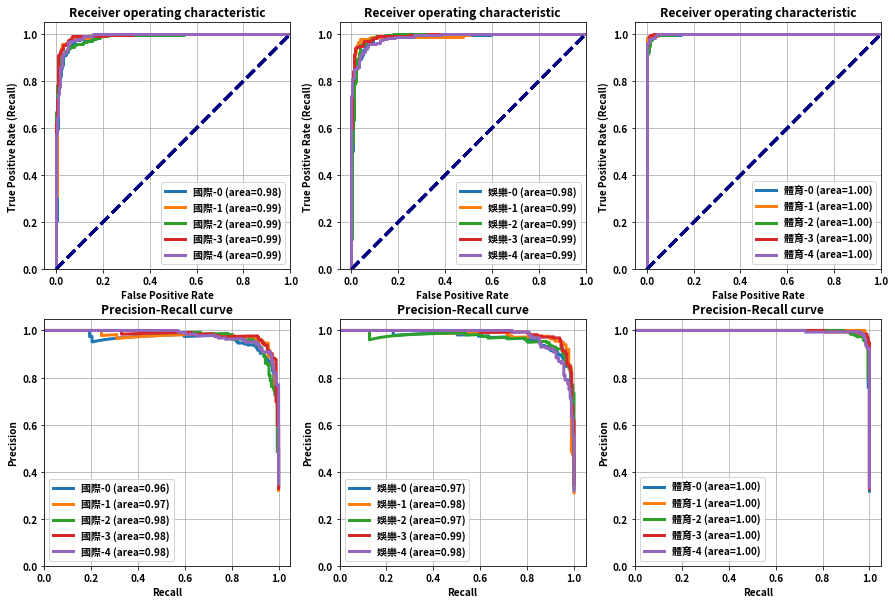

In [59]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [44]:
model_set[best_model_name]

LogisticRegression()

In [60]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

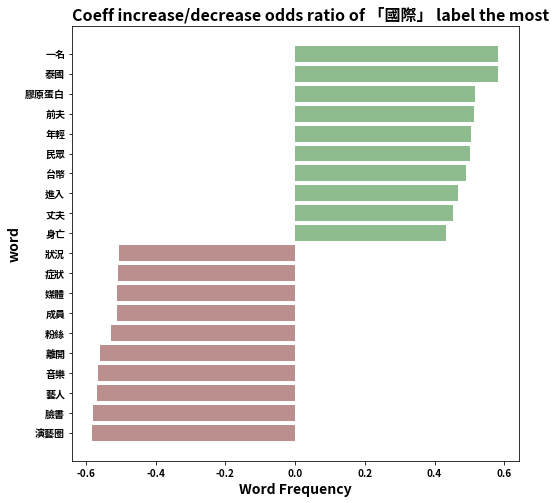

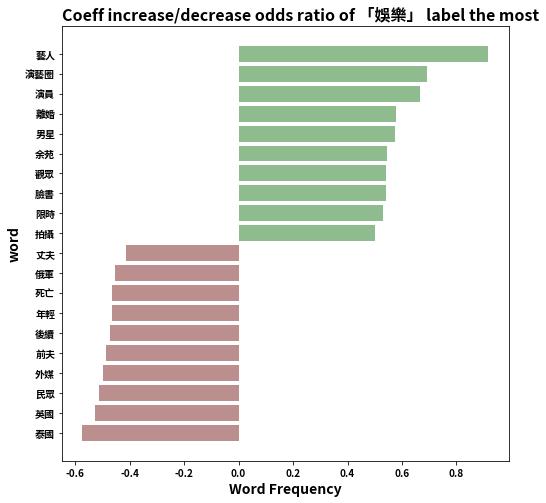

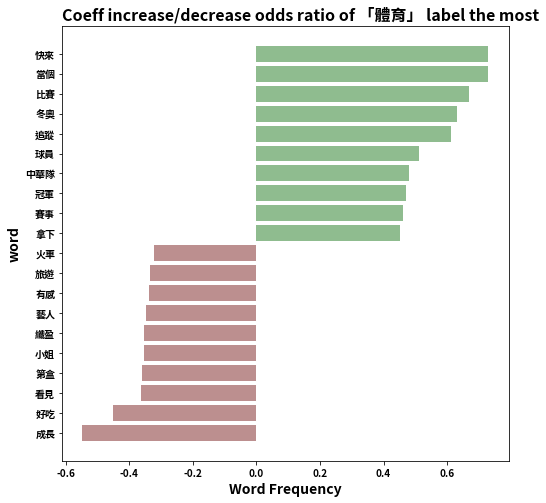

In [61]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names_out(), top_n=10)

可以看到在三個類別中高係數的字確實都跟該主題有關。

## 6. 預測新聞類別

In [62]:
ct = pd.read_csv("./raw_data/text_data.csv",index_col=0)
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,劉樂妍「感謝祖國媽媽」 嫌台灣防疫差：回去會被感染｜東森新聞,https://news.ebc.net.tw/news/article/243458,2021-01-01 00:11:00,娛樂,親中女星劉樂妍近年將演藝重心移往對岸，目前在中國河北省燕郊鎮定居，今（31日）她在微博曬出一...,EBC
1,2,五月天演唱會「警方帶離歌迷」 相信音樂證實：疑似自主健康管理者｜東森新聞,https://news.ebc.net.tw/news/article/243459,2021-01-01 00:36:00,娛樂,五月天今（31）日跨年夜在桃園棒球場舉辦「好好好想見到你」演唱會，現場吸引2.2萬名五迷齊聚...,EBC
2,3,蕭敬騰跨年演唱會慘摔 緊握麥克風繼續唱：讓大家擔心了｜東森新聞,https://news.ebc.net.tw/news/article/243461,2021-01-01 00:58:00,娛樂,「台北最HIGH新年城-2021跨年晚會」31日下午6點30分在市民廣場盛大舉行，在跨年煙火...,EBC
3,4,1人抵全台！網狂推「這一位」是跨年MVP：無庸置疑｜東森新聞,https://news.ebc.net.tw/news/article/243478,2021-01-01 09:06:00,娛樂,2020年因為受到新冠肺炎疫情的影響，除了台北市和台東縣阿妹的跨年演唱會等等以外，許多縣市的...,EBC
4,5,《愛的迫降》假戲真做！玄彬、孫藝真遭爆戀愛8個月｜東森新聞,https://news.ebc.net.tw/news/article/243481,2021-01-01 09:15:00,娛樂,韓劇愛的迫降是真的！南韓藝人玄彬、孫藝真因這部戲被許多粉絲期待能在一起，而日前南韓最強狗仔D...,EBC
...,...,...,...,...,...,...,...
5542,618,東京奧運明年舉行！ 國際奧會：將在安全環境下舉辦｜東森新聞,https://news.ebc.net.tw/news/article/226296,2020-09-10 11:08:00,體育,原定今年登場的東京奧運因武漢肺炎疫情延至明年，國際奧會日前說，無論如何明年奧運都會如期舉行，...,EBC
5543,1584,戴資穎回來「讓她吃飽喝撐」！球評姊曬超萌合照：我們多久沒拍照了｜東森新聞,https://news.ebc.net.tw/news/article/272561,2021-08-02 09:50:00,體育,「世界球后」戴資穎昨（1）日對戰中國好手陳雨菲，最後以18比21、21比19、18比21落敗...,EBC
5544,1375,「桌球教父」莊智淵止步16強！賴清德大讚：你永遠是台灣的驕傲｜東森新聞,https://news.ebc.net.tw/news/article/271985,2021-07-28 14:24:00,體育,東京奧運男子桌球單打於昨（27）日晚間進行比賽，我國「桌球教父」莊智淵對決埃及選手阿薩爾（O...,EBC
5545,565,外媒爆梅西動向 轉戰曼城呼聲高｜東森新聞,https://news.ebc.net.tw/news/article/224228,2020-08-26 21:17:00,體育,巴塞隆納看板球星梅西決定離隊，多家外媒的消息都指向梅西可能轉戰曼城，美媒ESPN報導，曼城總...,EBC


In [63]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,劉樂妍「感謝祖國媽媽」 嫌台灣防疫差：回去會被感染｜東森新聞親中女星劉樂妍近年將演藝重心移往...,https://news.ebc.net.tw/news/article/243458,娛樂,劉樂妍 感謝 祖國 媽媽 台灣 防疫 回去 感染 東森 新聞 親中 女星 劉樂妍 近年 演藝...
1,五月天演唱會「警方帶離歌迷」 相信音樂證實：疑似自主健康管理者｜東森新聞五月天今（31）日跨...,https://news.ebc.net.tw/news/article/243459,娛樂,五月天 演唱會 警方 帶離 歌迷 相信 音樂 證實 疑似 自主 健康 管理者 東森 新聞 五...
2,蕭敬騰跨年演唱會慘摔 緊握麥克風繼續唱：讓大家擔心了｜東森新聞「台北最HIGH新年城-202...,https://news.ebc.net.tw/news/article/243461,娛樂,蕭敬騰 演唱會 慘摔 緊握 麥克風 繼續 擔心 東森 新聞 台北 HIGH 新年 2021 ...
3,1人抵全台！網狂推「這一位」是跨年MVP：無庸置疑｜東森新聞2020年因為受到新冠肺炎疫情的...,https://news.ebc.net.tw/news/article/243478,娛樂,人抵 全台 網狂 一位 MVP 無庸置疑 東森 新聞 2020 受到 新冠 肺炎 疫情 影響...
4,《愛的迫降》假戲真做！玄彬、孫藝真遭爆戀愛8個月｜東森新聞韓劇愛的迫降是真的！南韓藝人玄彬、...,https://news.ebc.net.tw/news/article/243481,娛樂,愛的 迫降 假戲真做 玄彬 孫藝真 遭爆 戀愛 東森 新聞 韓劇 愛的 迫降 真的 南韓 藝...


In [64]:
ct['artCatagory'].value_counts()

artCatagory
娛樂    1849
國際    1849
體育    1849
Name: count, dtype: int64

In [65]:
# mapper = {"財經":"股市", "政治":"兩岸", "體育":"運動", "兩岸": "兩岸"}
# ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          國際       0.37      1.00      0.54      1849
          娛樂       1.00      0.01      0.01      1849
          體育       0.99      0.28      0.43      1849

    accuracy                           0.43      5547
   macro avg       0.79      0.43      0.33      5547
weighted avg       0.79      0.43      0.33      5547



In [66]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,劉樂妍 感謝 祖國 媽媽 台灣 防疫 回去 感染 東森 新聞 親中 女星 劉樂妍 近年 演藝...,娛樂,國際
1,五月天 演唱會 警方 帶離 歌迷 相信 音樂 證實 疑似 自主 健康 管理者 東森 新聞 五...,娛樂,國際
2,蕭敬騰 演唱會 慘摔 緊握 麥克風 繼續 擔心 東森 新聞 台北 HIGH 新年 2021 ...,娛樂,國際
3,人抵 全台 網狂 一位 MVP 無庸置疑 東森 新聞 2020 受到 新冠 肺炎 疫情 影響...,娛樂,國際
4,愛的 迫降 假戲真做 玄彬 孫藝真 遭爆 戀愛 東森 新聞 韓劇 愛的 迫降 真的 南韓 藝...,娛樂,國際
...,...,...,...
5542,東京 奧運 明年 舉行 國際 奧會 將在 安全 環境 舉辦 東森 新聞 原定 今年 登場 東...,體育,國際
5543,戴資穎 回來 吃飽 喝撐 球評 超萌 合照 多久 拍照 東森 新聞 世界 球后 戴資穎 對戰...,體育,體育
5544,桌球 教父 莊智淵 止步 16 賴清德 永遠 台灣 驕傲 東森 新聞 東京 奧運 男子 桌球...,體育,國際
5545,外媒 爆梅西 動向 轉戰 曼城 呼聲 東森 新聞 巴塞隆納 球星 梅西 決定 離隊 多家 外...,體育,國際


In [67]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,劉樂妍 感謝 祖國 媽媽 台灣 防疫 回去 感染 東森 新聞 親中 女星 劉樂妍 近年 演藝...,娛樂,國際
1,五月天 演唱會 警方 帶離 歌迷 相信 音樂 證實 疑似 自主 健康 管理者 東森 新聞 五...,娛樂,國際
2,蕭敬騰 演唱會 慘摔 緊握 麥克風 繼續 擔心 東森 新聞 台北 HIGH 新年 2021 ...,娛樂,國際
3,人抵 全台 網狂 一位 MVP 無庸置疑 東森 新聞 2020 受到 新冠 肺炎 疫情 影響...,娛樂,國際
4,愛的 迫降 假戲真做 玄彬 孫藝真 遭爆 戀愛 東森 新聞 韓劇 愛的 迫降 真的 南韓 藝...,娛樂,國際
...,...,...,...
5541,5.4 NBA 快艇 簽下 暴龍 球星 伊巴 東森 新聞 多家 媒體 今天 晚間 報導 美國...,體育,國際
5542,東京 奧運 明年 舉行 國際 奧會 將在 安全 環境 舉辦 東森 新聞 原定 今年 登場 東...,體育,國際
5544,桌球 教父 莊智淵 止步 16 賴清德 永遠 台灣 驕傲 東森 新聞 東京 奧運 男子 桌球...,體育,國際
5545,外媒 爆梅西 動向 轉戰 曼城 呼聲 東森 新聞 巴塞隆納 球星 梅西 決定 離隊 多家 外...,體育,國際


In [68]:
false_pred.loc[false_pred['artCatagory']=='股市', :]

,words,artCatagory,pred


In [69]:
pprint(false_pred['words'][74])

('李李仁 道歉 球場 失態 中指 將親 致電 對手 教練 東森 新聞 李李仁 遭到 爆料 女兒 越級 打球 舉報 對手 教練 中指 發生衝突 李李仁 凌晨 '
 '已經 發文 道歉 眼見 此事 引起 關注 做出 良好 身教 下午 致電 對手 教練 表達 誠摯 歉意 2021 專屬 愛情 幸運 關鍵字 李李仁 愛女 '
 '上個月 中以 國三生 身分 學校 教練 報上 高中生 資格 HBL 比賽 還沒 上場 對方 教練 糾舉 資格 不符 無法 參加 比賽 李李仁 女兒 '
 '抱不平 對方 教練 中指 講出 情緒 比較 激烈 話語 造成 在場 觀眾 覺得 失態 深夜 已經 IG 發文 致歉 眼見 這件 事情 牽扯 老婆 陶子 '
 '小孩 李李仁 認為 公眾 人物 做出 良好 示範 認錯 透過 熟悉 籃球 錢韋杉 聯絡 當事 教練 表示 想要 致電 道歉 表現 最大 誠意 事件 平息 '
 '這場 HBL 球賽 晉級 兩所 學校 校隊 相當 重視 彼此間 場上 廝殺 比賽 結束 雙方 情緒 會將 李李仁 搬上 檯面 成年人 出面 處理 剩下 '
 '未成年 學生 情緒 雙方 溝通 運動 回歸 運動 延伸 閱讀 星爸 叫囂 護女 陶晶瑩 直播 澄清 幫腔 寶特瓶 加油 星爸 叫囂 護女 李李仁 教練 '
 '中指 惹議 緩頰 明星 夫妻 凡人 星爸 叫囂 護女 護女 心切 李李仁 HBL 賽場 中指 深夜 道歉 我會 長大 星爸 叫囂 護女 女兒 揪出 違規 '
 '參賽 李李仁 中指 陶子 不平')


將2020年的新聞作為分類測試資料，可以看到分類準確率依然很高

## 6. 教學目標
1. 能夠利用 DTM 將文章表示成一串數字，以利後續的分析或預測任務使用
2. 能夠使用機器學習流程，訓練一個文集分類模型
    * 額外提問：只要能夠把文字資料轉換成 `input` 與 `label` 的形式，就能夠來訓練預測模型。例如本週就是將新聞轉成數字 input，label 為新聞類別。文字分析中有哪些可能的應用場景？
        * 用企業的財報預測企業股價/ROA?
        * 用總統候選人的選前演講稿預測得票率？
3. 能夠解釋在可解釋模型中，詞頻/tfidf 作為 input feature 的意義

## 附錄

In [70]:
# 定義模型訓練組合
## 不做 cross validation, 用 test data 來評估模型的版本
## pipeline: 資料處理 vectorizer + 分類器
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)
    

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

          國際       0.93      0.92      0.92       409
          娛樂       0.92      0.92      0.92       419
          體育       0.98      0.99      0.98       402

    accuracy                           0.94      1230
   macro avg       0.94      0.94      0.94      1230
weighted avg       0.94      0.94      0.94      1230



d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


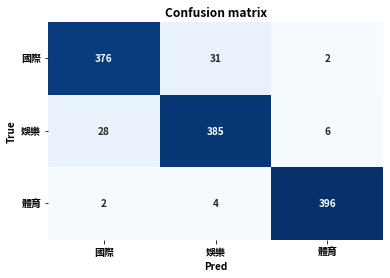

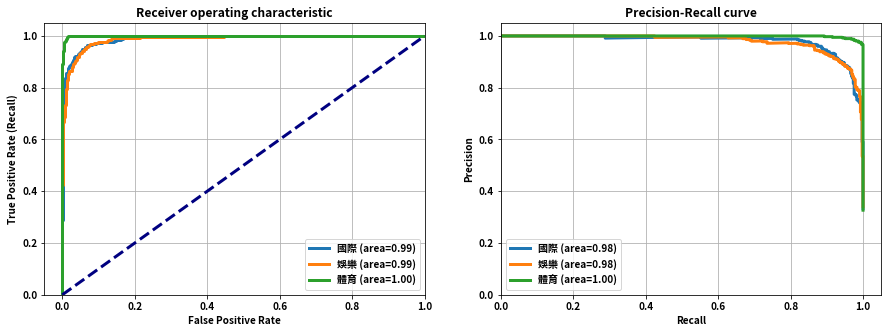

{'國際': {'precision': 0.9261083743842364,
  'recall': 0.9193154034229829,
  'f1-score': 0.9226993865030674,
  'support': 409},
 '娛樂': {'precision': 0.9166666666666666,
  'recall': 0.918854415274463,
  'f1-score': 0.9177592371871275,
  'support': 419},
 '體育': {'precision': 0.9801980198019802,
  'recall': 0.9850746268656716,
  'f1-score': 0.9826302729528535,
  'support': 402},
 'accuracy': 0.9406504065040651,
 'macro avg': {'precision': 0.9409910202842945,
  'recall': 0.9410814818543726,
  'f1-score': 0.9410296322143495,
  'support': 1230},
 'weighted avg': {'precision': 0.9405701320462455,
  'recall': 0.9406504065040651,
  'f1-score': 0.9406036903969173,
  'support': 1230}}

In [71]:
data = ebc
X = data["words"]
y = data["artCatagory"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
train(vectorizer, clf, X_train, y_train, X_test, y_test)

    畫出決策樹的 code

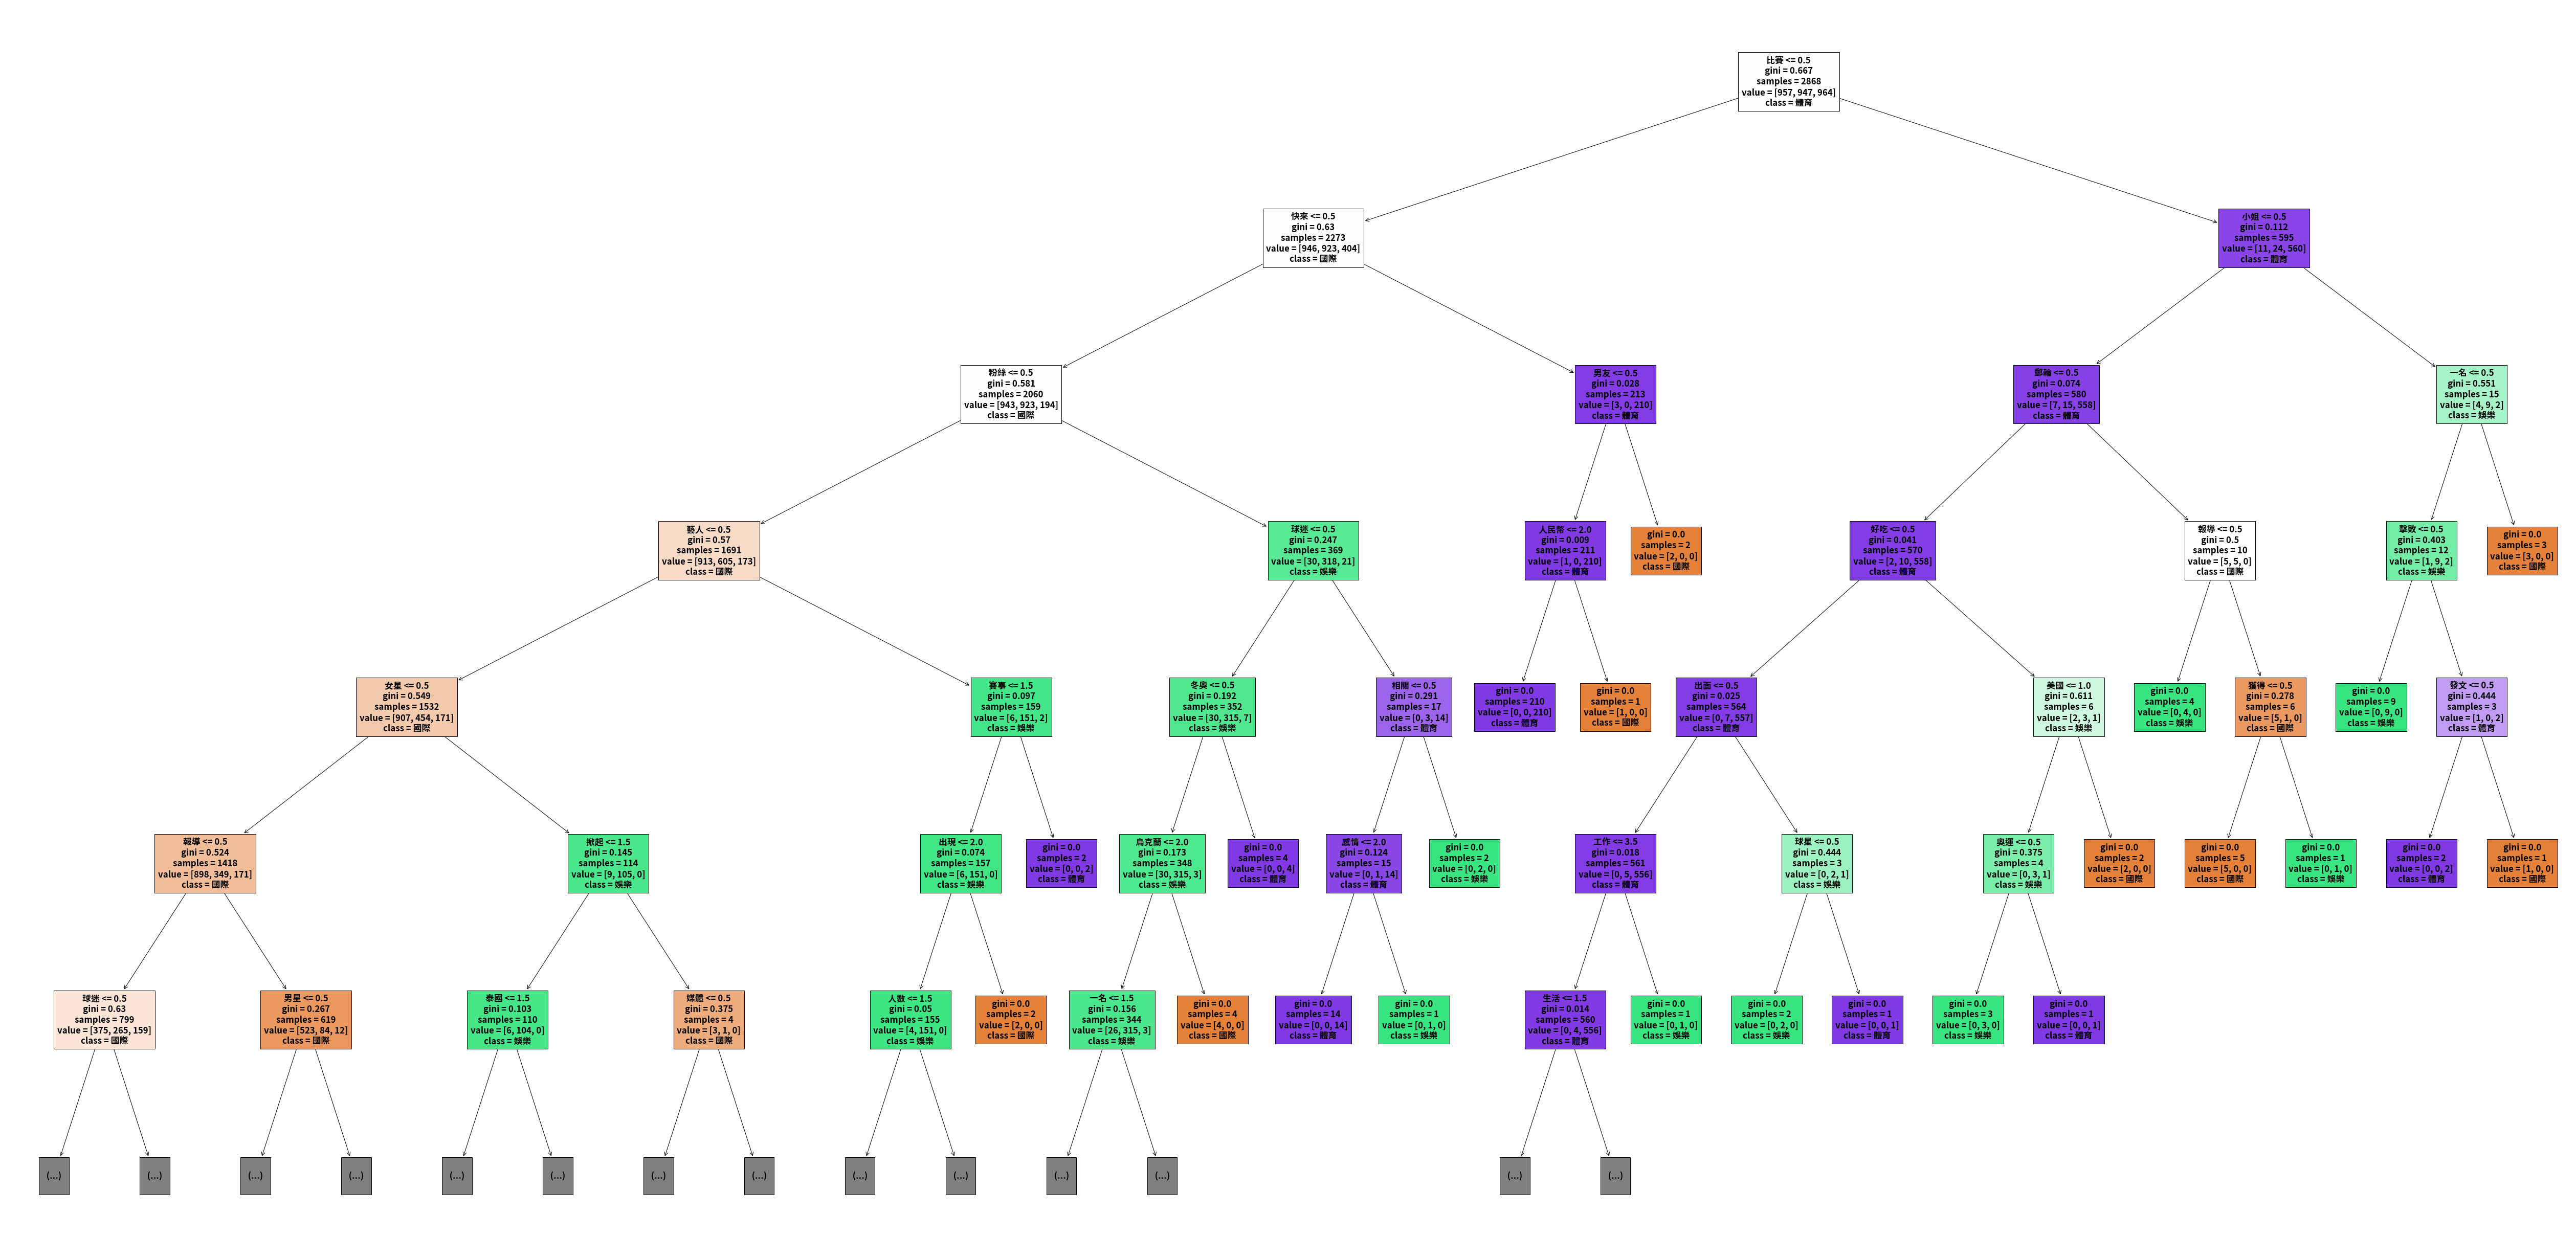

In [72]:
fig = plt.figure()
fig.set_size_inches(90, 45)
plot_tree(
    model_set["clf_dtree"], 
    max_depth=6, # 最大深度
    feature_names=vectorizer.get_feature_names_out(), 
    class_names=model_set["clf_dtree"].classes_,
    filled=True
)
fig.savefig("decistion_tree.png")